In [1]:
import numpy as np
import torch
from torch import rand
import torch.nn as nn
from qadence import Parameter, QuantumCircuit, QuantumModel, QNN, kron, ising_hamiltonian, hea, chain, add, Z
from qadence.constructors import feature_map, hamiltonian_factory
import matplotlib.pyplot as plt

In [2]:
def boundary_condition(model, input):
    #input = torch.cat([x_train, y_train], dim=1)
    x_1 = input
    y_1 = input
    x_2 = input
    y_2 = input
    x_1[:,1] = 0
    y_1[:,0] = 0
    x_2[:,1] = 1
    y_2[:,0] = 1
    
    # u(0, y) = sin(πy)
    first = (model(y_1) - torch.sin(torch.pi * model(y_1)))**2
    
    # u(1, y) = exp(-π) * sin(πy)
    second = (model(y_2) - torch.exp(torch.tensor(-torch.pi)) * torch.sin(torch.pi * model(y_2)))**2

    
    # u(x, 0) = 0
    third = (model(x_1) - 0)**2
    
    # (x, 1) = 0
    fourth = (model(x_2) - 0)**2
    
    return first + second + third + fourth

In [3]:
def create_qnn_model():
    n_qubits = 6
    depth = 6
    variable = ("x", "y")
    ansatz = hea(n_qubits=n_qubits, depth=depth)
    split = n_qubits // len(variable)

    feature_maps = [
        feature_map(n_qubits=split, support=support, param=param)
        for param, support in zip(variable,
            [
                list(range(n_qubits))[i : i + split]
                for i in range(0, n_qubits, split)
            ],
        )
    ]
    fm = kron(*feature_maps)

    obs = add(Z(i) for i in range(n_qubits))  #ising_hamiltonian(n_qubits=n_qubits)

    circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
    model = QNN(circuit=circuit, observable=obs, inputs=variable)
    
    return model

In [4]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(outputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

In [5]:
def pde_loss(model, inp, x, y):

    bc = boundary_condition(model, inp)
    bc_term = torch.mean(bc)

    inp.requires_grad_(True)
    
    u = model(inp)
    
    first_deriv = calc_deriv(u,inp)
    second_deriv = calc_deriv(first_deriv,inp)
    
    pde_term = second_deriv[:,0] + second_deriv[:,1]
    
    return torch.mean(pde_term ** 2) + bc_term

In [6]:
def train_model(model, optimizer, n_epochs=400):
    for epoch in range(n_epochs):
        nx, ny = 40, 40
        x = np.random.uniform(0, 1, nx)
        y = np.random.uniform(0, 1, ny)
        X, Y = np.meshgrid(x, y)

        x_train = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
        y_train = torch.tensor(Y.flatten(), dtype=torch.float32).reshape(-1, 1)
        inputs = torch.cat([x_train, y_train], dim=1)
        optimizer.zero_grad()
        
        loss = pde_loss(model, inputs, x_train, y_train)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0 or epoch == 399:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

In [ ]:
model = create_qnn_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(model, optimizer)

Epoch 0, Loss: 1.787006
Epoch 100, Loss: 0.000007
Epoch 200, Loss: 0.000000
Epoch 300, Loss: 0.000000
Epoch 399, Loss: 0.000000


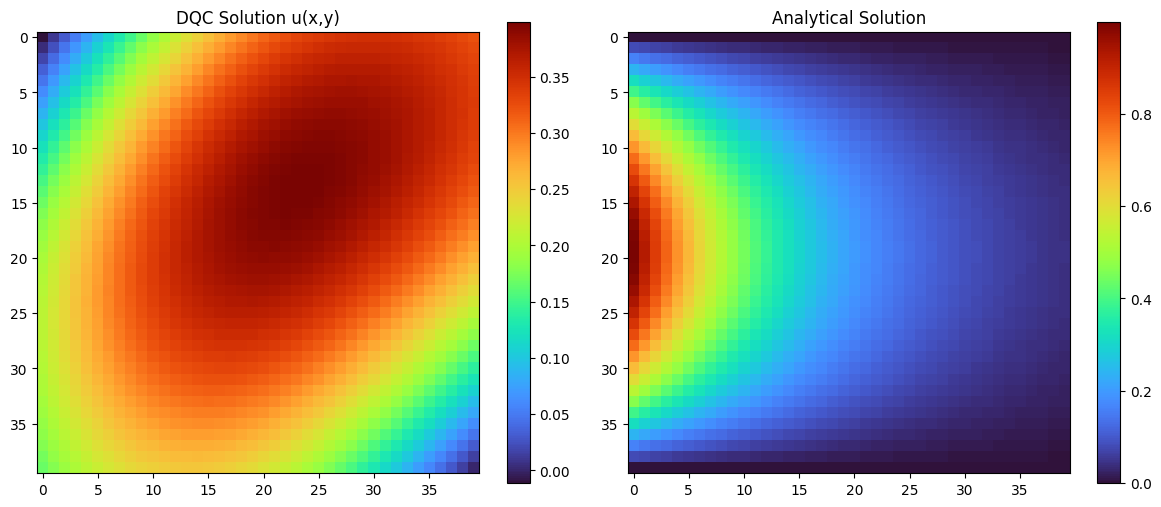

In [ ]:
nx, ny = 40, 40
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
x_train = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
y_train = torch.tensor(Y.flatten(), dtype=torch.float32).reshape(-1, 1)
inputs = torch.cat([x_train, y_train], dim=1)
def plot_solution(model):
    with torch.no_grad():
        u_pred = model(inputs).reshape(nx, ny)
        
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(u_pred.detach().numpy(), cmap='turbo')
    plt.colorbar()
    plt.title('DQC Solution u(x,y)')
    
    plt.subplot(1, 2, 2)
    analytical = np.sin(np.pi * Y) * np.exp(-np.pi * X)
    plt.imshow(analytical, cmap='turbo')
    plt.colorbar()
    plt.title('Analytical Solution')
    
    plt.tight_layout()
    plt.show()

plot_solution(model)